# Predictor Evaluation and Visualization

In [2]:
import os
os.chdir('/app/Pogona_realtime/Arena')

## Imports

In [3]:
import numpy as np
import pandas as pd
import pickle
import imp
import json
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.widgets import Slider
import seaborn as sns
#from tqdm.auto import tqdm
from tqdm import tqdm
import torch
import glob
from datetime import datetime
import cv2 as cv


from Prediction import dataset
from Prediction import train_eval
from Prediction import predictor
from Prediction import visualize
from Prediction import detector
from Prediction import kalman_predict
from Prediction import seq2seq_predict
from Prediction import calibration as calib

In [55]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(detector)
imp.reload(dataset)
imp.reload(kalman_predict)

<module 'Prediction.kalman_predict' from '/app/Pogona_realtime/Arena/Prediction/kalman_predict.py'>

## Load data

In [88]:
all_df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

46 trials loaded


In [163]:
trials = all_df.index.unique()

## Load Trajectory Predictor and Hit Predictor

### Predictor parameters

In [90]:
input_labels = ['x1', 'y1', 'x2', 'y2']
output_labels = ['x1', 'y1', 'x2', 'y2']
input_dim = len(input_labels)
output_dim = len(output_labels)

inp_seq_len = 20
out_seq_len = 20
embedding_size = 4  # only used in supporting models.
hidden_size = 350
rnn_layers = 1
dropout = 0.2

batch_size = 256

In [ ]:
# Kalman Trajectory Predictor
traj_predictor = kalman_predict.KalmanPredictor(forecast_horizon=20, 
                                                num_derivatives=1, 
                                                q_var=0.3, r_var=1.0)

In [ ]:
model_type = 'LSTMdense'
net = seq2seq_predict.LSTMdense(out_seq_len, hidden_size=hidden_size, 
                     embedding_size=embedding_size, LSTM_layers=rnn_layers, dropout=dropout)

In [6]:
model_type = 'GRUEncDec'
net = seq2seq_predict.GRUEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, GRU_layers=rnn_layers,
                     tie_enc_dec=False, use_gru_cell=True, dropout=dropout)

In [8]:
# Seq2Seq Trajectory Predictor
#model_path = 'Prediction/traj_models/model_20_20_h64_b128_l1_LSTMdense_c1_36_best.pth'
#model_path = 'Prediction/traj_models/GRUEncDec_0915-1624_i20_o20_h128_b128_l1_66_best.pth'
#model_path = 'Prediction/traj_models/GRUEncDec_0916-034907_i20_o20_b128_10_best.pth' # ax best
#model_path = 'Prediction/traj_models/GRUEncDec_0921-1559_i20_o20_h350_b256_l1_15_best.pth'
model_path = 'Prediction/traj_models/GRUEncDec_rndloss_0921-1912_i20_o20_h350_b256_l1_20_best.pth'

traj_predictor = seq2seq_predict.Seq2SeqPredictor(net, model_path, 20, 20)

In [9]:
hit_predictor = predictor.HitPredictor(traj_predictor, detector=None)

### Masking

In [58]:
mask_fn = train_eval.keep_mask(train_eval.compose_masks(mask_fns=[
    #train_eval.mask_fl_dist(min_dist=0, max_dist=0, by_X=True, by_Y=True),
    #train_eval.mask_speed(min_speed=10, max_speed=20, by_X=True, by_Y=True),
    #train_eval.mask_std(min_std=0, max_std=0,cols=[0,1]),
    #train_eval.mask_corr(min_corr=0.0, max_corr=0.0, by_X=True, by_Y=True),
    train_eval.mask_zgzg(min_zgzg=0, max_zgzg=np.pi/2, by_X=True, by_Y=True)
    ]),keep_prob=0.0)

### Draw sequences function

In [93]:
def draw_sequences(arr_X,
                   arr_Y,
                   arr_pred,
                   ax,
                   to_scatter=True,
                   l_alpha=0.35,
                   sctr_s=0.5,
                   sctr_alpha=1,
                   past_c='b', ftr_c='r', pred_c='g', diff_c='k',
                   draw_diffs=True,
                   zoom_x = None,
                   zoom_y = None):
    
    if len(arr_X.shape)==2:
        arr_X = arr_X.reshape(1,arr_X.shape[0],arr_X.shape[1])
        arr_Y = arr_Y.reshape(1,arr_Y.shape[0],arr_Y.shape[1])
        if draw_diffs:
            arr_pred = arr_pred.reshape(1,arr_pred.shape[0],arr_pred.shape[1])
    
    ax.add_collection(LineCollection(segments=[seq for seq in arr_X[:,:,:2]], colors=[past_c], label='past',alpha=l_alpha))
    ax.add_collection(LineCollection(segments=[seq for seq in arr_Y[:,:,:2]], colors=[ftr_c], label='future',alpha=l_alpha))
    if draw_diffs:
        ax.add_collection(LineCollection(segments=[seq for seq in arr_pred[:,:,:2]], colors=[pred_c],label='pred',alpha=l_alpha))
        diffs = [np.array([arr_pred[j,i,:2],arr_Y[j,i,:2]]) for i in range(out_seq_len) for j in range(arr_pred.shape[0])]
        ax.add_collection(LineCollection(segments=diffs, colors=[diff_c],label='diff',alpha=l_alpha))
    if to_scatter:
        ax.scatter(arr_X[:,:,0], arr_X[:,:,1], s=sctr_s, color=past_c, alpha=sctr_alpha)
        ax.scatter(arr_Y[:,:,0], arr_Y[:,:,1], s=sctr_s, color=ftr_c, alpha=sctr_alpha)
        if draw_diffs:
            ax.scatter(arr_pred[:,:,0], arr_pred[:,:,1], s=sctr_s, color=pred_c, alpha=sctr_alpha)
            
    if zoom_x:
        ax.set_xlim(zoom_x)
    if zoom_y:
        ax.set_ylim(zoom_y)


## Video sequence widget

In [94]:
trial = trials[0]
trial_df = all_df.loc[trial]
vid_path = dataset.get_trial_video_path(trial)
homography = dataset.homography_for_trial(trial)
correction_fn = visualize.get_correction_fn(homography, 1920)

In [104]:
X_trial, Y_trial = train_eval.trial_to_samples(trial_df, 
                                               input_labels, output_labels, 
                                               inp_seq_len, out_seq_len, 
                                               keep_nans=True)

X_trial, Y_trial = X_trial.numpy(), Y_trial.numpy()

In [156]:
trial_mask = mask_fn(X_trial, Y_trial)
trial_mask.sum()

331

In [133]:
def get_vid_frames(vid_path, correction_fn, start, num):
    vcap = cv.VideoCapture(vid_path)
    vcap.set(cv.CAP_PROP_POS_FRAMES, start)
    frames = []
    for i in range(num):
        ret, frame = vcap.read()
        frames.append(correction_fn(frame))
        
    return frames

In [162]:
%matplotlib widget

# choose random sequnce
if not np.any(trial_mask):
    raise Exception('Data mask is all False')
seq_num = np.random.choice(np.argwhere(trial_mask).squeeze())

seq = X_trial[seq_num], Y_trial[seq_num]
alpha = 1/(inp_seq_len+out_seq_len)
cat_seq = np.concatenate(seq)
frames = get_vid_frames(vid_path, correction_fn, seq_num, inp_seq_len+out_seq_len)

fig, ax = plt.subplots(1, 1, figsize=(7,8))
plt.subplots_adjust(left=0.25, bottom=0.1)
fig.suptitle(f"Trial: {trial} sequence num: {seq_num}\n masked: {trial_mask.sum()}")

ax_im = ax.imshow(frames[0])
draw_sequences(X_trial[seq_num], Y_trial[seq_num], None, ax, draw_diffs=False)
ax_cur_point = ax.scatter(seq[0][0, 0], seq[0][0, 1], c='g')

slider_ax = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(slider_ax, "timestep", 0, inp_seq_len+out_seq_len, valinit=0, valstep=1)

def update_timestep(t):
    t = int(t)
    ax_im.set_data(frames[t])
    if t >= inp_seq_len:
        idx = t - inp_seq_len
        ax_cur_point.set_offsets([seq[1][idx, 0], seq[1][idx, 1]])
    else:
        ax_cur_point.set_offsets([seq[0][t, 0], seq[0][t, 1]])
    
    fig.canvas.draw_idle()

slider.on_changed(update_timestep)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0

## Visualize trial trajectories

Timings for predictors (20/20)
- gru = 3.8ms
- grucell = 3.14ms or even lower
- LSTMdense = 0.6ms
- vel_linear =0.2ms
- kalman = 0.09ms

In [23]:
lots_o_touches = 'circle_20200803T115839_trial1'
lots_o_touches2 = 'fast_cockroach_20200803T085738_trial1'

In [24]:
#trial_data = val[1]
trial_data = lots_o_touches2
bboxes = all_df.loc[trial_data][['x1','y1','x2','y2']].values

FIRST_FRAME = 0

bboxes = bboxes[FIRST_FRAME:] 
# TODO - slicing bbox array creates a discrepency between the forecasts and the dataframe?
# might 
#bboxes[60:70] = np.nan
eval_results, forecasts = train_eval.eval_trajectory_predictor(traj_predictor, bboxes)

100%|██████████| 5061/5061 [00:00<00:00, 10449.42it/s]


### Plot entire trial trajectory

In [25]:
def gen_forecasts_path(forecasts, n=0):
    # first_forecast - the first forecast which doesn't contain any np.nan
    first_forecast = next(i for i, fc in enumerate(forecasts) if fc is not None and not np.any(np.isnan(fc)))
    path = np.empty((len(forecasts) - first_forecast - 1, 4))
    # create the entire path from the forecasts
    for i in range(path.shape[0]):
        path[i] = forecasts[first_forecast + i][n]
    return path, first_forecast

In [27]:
X1, Y1, X2, Y2 = 0, 1, 2, 3

# TODO - maybe function
n = 10
fpath, first_f = gen_forecasts_path(forecasts, n=n)
fpath = np.roll(fpath, n+1, axis=0)
fpath[:n+1] = np.nan
rpath = bboxes #[first_f+1:]

fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')

# change these parameters to inspect only a single path and make the others less visible
# can also use zorder paramater to control the oreder of plots
real_alpha = 0.5
fore_alpha = 0.0
diff_alpha = 0.0

# plot top left, bottom right coordinates of recorded path
ax.plot(rpath[:, X2], rpath[:, Y2], color="r" ,label = 'real_x2y2', alpha=real_alpha)
ax.plot(rpath[:, X1], rpath[:, Y1], color="m", label = 'real_x1y1', alpha=real_alpha)

# plot top left, bottom right coordinates of predicted path
ax.plot(fpath[:, X2], fpath[:, Y2], color="c",label = 'forecast_x2y2', alpha=fore_alpha)
ax.plot(fpath[:, X1], fpath[:, Y1], color="b",label = 'forecast_x1y1', alpha=fore_alpha)

print(len(fpath), len(rpath), first_f, len(forecasts), len(bboxes))
lines = np.stack([fpath[:, 0:2], rpath[first_f+1:, 0:2]], axis=1)
ax.add_collection(LineCollection(lines, colors=['r'],alpha=diff_alpha, label = "diff_x1y1"))

lines2 = np.stack([fpath[:, 2:4], rpath[first_f+1:, 2:4]], axis=1)
ax.add_collection(LineCollection(lines2, colors=['orange'], alpha=diff_alpha, label = "diff_x2y2"))
#ax.set_xlim([0,1920])
#ax.set_ylim([-200,3500])
ax.plot(np.linspace(0,1920,num=5),np.zeros(5),linestyle='--', color='r')

ax.legend()
print(trial_data)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

5060 5081 20 5081 5081
fast_cockroach_20200803T085738_trial1


### Plot all preictions per timestep

In [29]:
def predictions_per_step(forecasts):
    first_forecast = next(i for i, fc in enumerate(forecasts) if fc is not None)
    forecast_len = forecasts[first_forecast].shape[0]
    preds = np.empty((len(forecasts) - first_forecast, forecast_len, 4))
    preds[:] = np.nan
    
    for i in range(preds.shape[0]):
        for j in range(max(0, i - forecast_len+1), i+1):
            f = forecasts[j]
            if f is not None:
                preds[i, i-j] = f[i-j]
    
    return preds

In [30]:
real_alpha = 0.5
fore_alpha = 0.5

preds = predictions_per_step(forecasts)
avgs = np.mean(preds, axis=1)
rpath = bboxes[first_f+1:]
npath = preds[:, 0]
plt.figure(figsize=(10,10))
plt.plot(rpath[:, X2], rpath[:, Y2], color='b', alpha=real_alpha, label='real')
plt.plot(avgs[:, X2], avgs[:, Y2], color='g',alpha=fore_alpha, label='forecast')
#plt.plot(npath[:, 0], npath[:, 1], color='r')
plt.axis('equal')
plt.legend()
plt.plot(np.linspace(0,1920,num=5),np.zeros(5),linestyle='--', color='r')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Evaluate Hit Predictor

Hit Prediction Evalutaion:<br>
For a trial with hit events, need to implement a function that outputs a structure that 
saves for each frame with a hit event, the forecasts that predicted a hit that occurs in that frame,
and the x values of every such prediction. The rationale for saving all of the forecasts that predicted a hit in a certain frame
is the that good predictions will ideally converge over consecutive forecasts.

Structure:<br>
For each frame in the video, create an array with dimensions forecast_horizon X 2 
(maybe just a 3d array, something like in predictions_per_step, and also save the x values)
Other idea - 2d array, (num_frames) X (forecast_horizon)

Functions:<br>
Iterate over forecasts which are not None, and threshold y2 values against y=0 in the arena (or some other y value).
If a bbox crosses the threshold for some forecast, save the index of the first crossing in the forecast, as a value in the relevant index of the frame.
For example, if the forecast_horizon is 20, and forecast 1000 (started from frame 1000) predicts a hit in it's 10 timestamp,
save the x value in index 10 in frame 1010. If forecast 1001 predicts an hit in it's 9th timestamp, save the value in index 9 in fram 1010.
Notice: for each frame, there are 20 indices: index 0 means that a forecast predicted a hit one frame in advance, index 8 means 12 frames in advance.

frame | forecast_0 | forecast_1 | ... | forecast_19
____________________________________________________
    0 | nan        |   x_1      | ... |    x_19    
    1 | x_0        |   x_1      | ... |    nan
    ....

from this, maybe a smaller array with columns "frame | num_forecasts_predicted_hit | mean_x_value"

Visualization:<br>
A horizontal indexed heatmap, where each timestamp is colored by the amount of forecasts that predict a hit
in that frame. On the same figure, plot with other colors the real hit events. 
It's a sort of a "raster plot".
Matplotlib function: "eventplot"
Also possible to generate a raster plot for each forecast seperatly - idealy, a hit event should be preceeded by a diagonal
pattern of predicted hits

TODO<br>
Maybe other visualiztions that combine the temporal data with the arena coordinates data.

Metrics - TODO:<br>
We can compare that structure to the real frames that have an actual hit event and their respective x values,
and calculate various metrics that quantify the errors. Join the the arrays.
FN - missed an hit event (by how much?)
FP - predicted an hit event by mistake (relative to what ground truth events?)
Other issues: how to decide what is a "close" event? what to do if there are many? etc...


In [31]:
# TODO: aligning with true touching events won't work, check FIRST_FRAME parameter from evaluate trajectory predictor cell

def get_hit_preds_forecasts(forecasts_list, 
                            hit_pred, 
                            y_thresh=0,
                            preds_forecasts=True,
                            return_mean=False):
    """
    Receive a forecasts list, and generate an array describing the hit predictions from the frame perspective,
    i.e, for each frame, there's a forecast_horizon shape row, with a value in the index of a forecast that 
    predicted a hit. (if forecast 1234 predicted hit in 5 frames, then pred[1239,5] has a value).
    
    if pred_forecasts is False, will return the opposite array of get_hit_preds_forecasts: 
    describes for each forecast, at which index they first predict a hit
    
    If return_mean is true, will count the number of forecasts predicting a hit for a specific frame, and the mean predicted
    x value.
    """
    if hit_pred.prediction_y_threshold != y_thresh:
        print(f"changed hit predictor y's thresh from {hit_pred.prediction_y_threshold} to {y_thresh}")
        hit_pred.prediction_y_threshold = y_thresh
    
    first_forecast = next(i for i, fc in enumerate(forecasts) if fc is not None) # if no forecasts, still return zero?
    if forecasts_list[first_forecast] is None:
        print("No forecasts in list")
        return
    
    forecast_horizon = forecasts_list[first_forecast].shape[0]
    preds = np.empty((len(forecasts_list), forecast_horizon))    
    preds[:] = np.nan
    
    for i, forecast in enumerate(forecasts_list[first_forecast:-forecast_horizon]):
        x2, hit_ind = hit_pred.predict_hit(forecast)
        if hit_ind is not None and hit_ind < preds.shape[0]:
            if preds_forecasts:
                frame_ind = first_forecast + (i+1) + hit_ind #  the frame index to which the hit is predicted
                preds[frame_ind, hit_ind] = x2  # place the x value in the index that the forecast predicted
            else:
                forecast_ind = first_forecast + (i+1) #  the forecast index which predicts the hit
                preds[forecast_ind, hit_ind] = x2  # place the x value in the index that the forecast predicted
    
    if preds_forecasts:
        if return_mean:
            temp = np.empty((preds.shape[0], 2))
            temp[:,0] = (~np.isnan(preds)).sum(axis=1) # number of forecasts predicting hit
            temp[:, 1] = np.nanmean(preds,axis=1)
            return temp
    return preds


def plot_preds_and_truth(preds, 
                         trial_slice, 
                         ax,
                         start=None, 
                         end=None,):
    """
    preds - a frame prediction array
    trial_slice - the slice from the dataframe for that trial, sliced like the bboxes array
    which the traj predictor operated on.
    Caller's responsibility to make sure the arrays are the same shape on dim 0 and that 
    they are aligned.
    """
    
    hits = False
    
    if start is None:
        start = 0
    if end is None:
        end = preds.shape[0]
    
    ax.set_xticklabels(np.arange(start=start, stop=end+1)) # ax.set_xticks set the integer indices of the labels
    
    preds = preds[start:end]
    trial_slice = trial_slice.iloc[start:end]
    
    forecast_horizon = preds.shape[1]
    if trial_slice is not None:
        hits_idx = np.where(trial_slice.is_touch)[0]
    
        if hits_idx.shape[0] == 0:
            print("no real hits")
        else:
            hits = True
    
    if np.all(np.isnan(preds)):
        print("All nan, nothing to show")
        return
    sns.heatmap(preds.transpose(), ax=ax)
        
    curr_x_ticks = list(ax.xaxis.get_ticklabels())
    stride = int(curr_x_ticks[1].get_text())
    ax.set_xticklabels(np.arange(start=start, stop=end+1,step=stride), rotation=30) # ax.set_xticks set the integer indices of the labels
    tick_freq = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % tick_freq != 0:
            label.set_visible(False)
        
    if hits:
        for x in hits_idx:
            ax.plot(np.ones(2)*x, np.linspace(0,20,num=2), linestyle='--',linewidth=1.5, color='g') 
    
   

In [ ]:
# old function, not important
def get_k_before_hits(df,k):
    """
    for each index of a hit row, slice the k>=1 previous rows (including hit) as a multiindex dataframe 
    with triple index: experiment, trial, hit-event. concatenate dataframes vertically
    TODO: COMPLETE DOC
    TODO: Move to Dataset module
    """
    assert type(k)==int
    assert k>0
    
    df_list = []
    for trial in df.index.unique():
        temp = df.loc[trial]
        temp = temp.is_touch
        
        if temp.sum() == 0:
            continue
        hits_ind = np.where(temp)[0]
        #display(hits_ind)
        #return
        event_list = []
        for j, hit_ind in enumerate(hits_ind):
            if j==0:
                min_slice = np.max([0,hit_ind-k])
            else:
                min_slice = np.max([0,hit_ind-k,hits_ind[j-1]])
            max_slice = hit_ind + 1
            sliced_event = df.loc[trial].iloc[min_slice:max_slice]
            #sliced_event.index = pd.MultiIndex.from_tuples([(trial[0], trial[1], j) for k in range(sliced_event.shape[0])])
            event_list.append(sliced_event)
        
        df_list.append(pd.concat(event_list))
    return pd.concat(df_list)

    

In [32]:
y_thrsh = 0

In [33]:
hit_preds = get_hit_preds_forecasts(forecasts_list=forecasts,
                                    hit_pred=hit_predictor,
                                    y_thresh=y_thrsh,
                                    return_mean=False)

In [34]:
forecast_preds = get_hit_preds_forecasts(forecasts_list=forecasts,
                                    hit_pred=hit_predictor,
                                    y_thresh=y_thrsh,
                                    preds_forecasts=False,
                                    return_mean=False)

In [126]:
start = 1700
end = 2000
fs = 20
pad = 40

In [ ]:
figs

Text(0.5, 1.0, 'Predictions of hit at frame $k$ (x) made $m$ timesteps ago (y)')

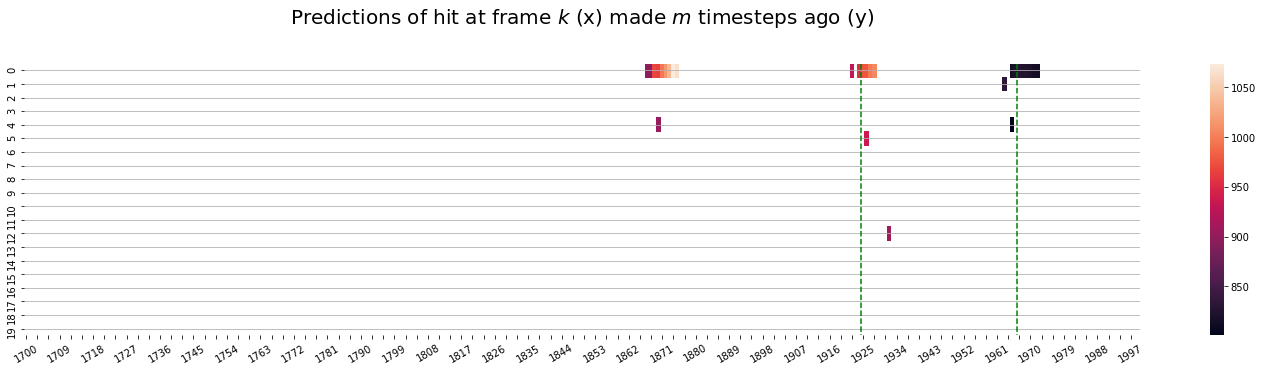

In [134]:
#%matplotlib widget
%matplotlib inline
fig, ax1 = plt.subplots(1,1,figsize=(25,5))
plot_preds_and_truth(hit_preds,
                     all_df.loc[trial_data],
                     ax1,
                     start=start,
                     end=end)
plt.grid(axis='y')
plt.title("Predictions of hit at frame $k$ (x) made $m$ timesteps ago (y)", fontsize=fs, pad=pad)

Text(0.5, 1.0, 'Predictions of forecasts made at frame $k$ (x) to hit in $m$ timesteps (y)')

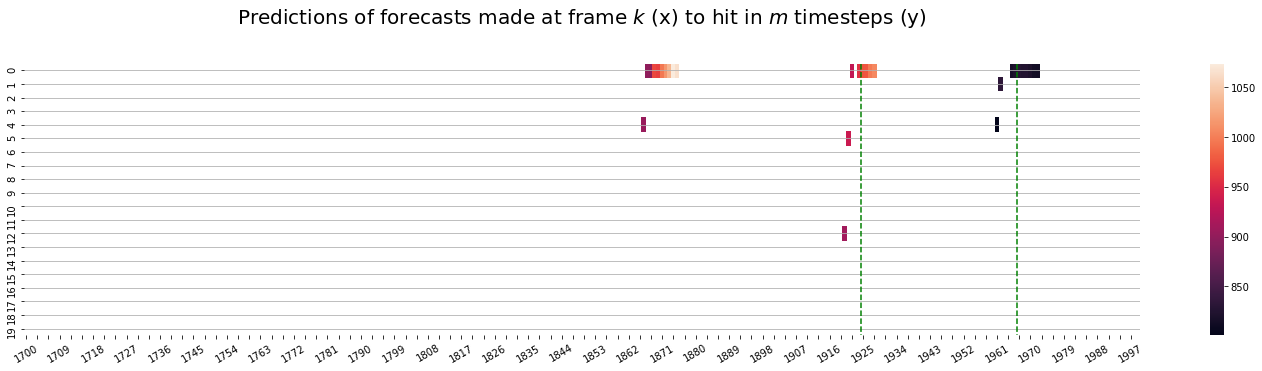

In [135]:
fig, ax2 = plt.subplots(1,1,figsize=(25,5))
plot_preds_and_truth(forecast_preds,
                     all_df.loc[trial_data],
                     ax2,
                     start=start,
                     end=end)
plt.grid(axis='y')
plt.title("Predictions of forecasts made at frame $k$ (x) to hit in $m$ timesteps (y)", fontsize=fs, pad=pad)


## Visualize multiple trajectories

#### General notes
Some general suggestions posts regarding training and generalization:
- https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn#

Most of the post deals with verifying the the correcteness of the data and the architecture. It doesn't seem that our network and\or data is malfunctioning.

- https://stats.stackexchange.com/questions/365778/what-should-i-do-when-my-neural-network-doesnt-generalize-well 

Dropout - in more layers 

Transfer learning from other movement dataset or even some language dataset? 

Data augmentation - take a smaller and more well chosen dataset, and expand it? maybe apply some linear transformations on the data, to both make the generalization better and have more data. Train a single model multiple times (or interchangingly) with diffrent input sequnce lengths - the weights don't change? filtering before training - applying an MA filter on the path will cause it to be less noisy, capturing the essential trend.

More regularization?

Early stopping - wev'e been doing it anyway, maybe make more concrete.

Generalization and metrics - what is a resonable validation/test error?  

#### __Ideas and observations from sequences plot:__
* Input-output length of 20 corresponds to 0.33 seconds. During fast movement, the animal can cover substential distance (in arena terms). Also, it's seems that 20 observations as input is way too much. if there's a trend in the input that seems somewhat predictive of the output, it will probably be in only the few last points. Moreover, some of the sequences of i20-o20, where X, Y or both are "long", i.e, "long" distance between first and last point, just seem "unlearnable". It's a relatively small portion of the entire dataset, but it seems that these are the sequences that matter most to the hit prediction. There's not alot to do with this other than state that this a hard problem to solve...
* A more practical question is this: what is the minimal time interval, where the course of an action (movement for example), can be changed by a decision? or in other words what is the maximal length of a path whose trajectory is controlled solely by mechanics and not decisions? it probably changes according to the type of action and it's initial velocity or accelaration. Reaction time and changing the course
* The feeding videos seems too dissimilar to the experiments data.
* The "sliding window artifcat"?

#### Directions:
- Data selection\filtering and augmentation (rotation). Maybe sequences with stride. Randomize loss length computation (until random K~U[1,out_seq_len]). The rationale - the errors from the distant timesteps, won't "hinder" the learning of short term movement.
- ADE as a function of input and output length.

In [22]:
inp_seq_len = 20
out_seq_len = 20

In [139]:
train, val, test = train_eval.create_train_val_test_splits(trials, [1, 0, 0])

In [146]:
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(df=all_df, 
                                                                         train=train, val=val, test=test, 
                                                                         input_labels=input_labels, output_labels=output_labels,
                                                                         input_seq_size=inp_seq_len,output_seq_size=out_seq_len, 
                                                                         batch_size=batch_size, 
                                                                         shuffle=False,
                                                                        mask_fn=None)                                                                        

In [153]:
""" 
TODO - Sequence level prediction? create seq_data_Yhat - the same dimensions as seq_data_Y. 
How to batch predict? and only on the test set?
"""
def get_seq_forecast(dataloader, traj_pred):
    forecasts_list = []
    
    with torch.no_grad():
        for x, y in dataloader:
            y_hat = traj_pred.model(x.float().to(traj_pred.model.device)).cpu().numpy()
            forecasts_list.append(y_hat)
    return np.concatenate(forecasts_list)

In [154]:
dl = train_dl
seq_data_X = dl.dataset.X.numpy()[:,:,2:]
seq_data_Y = dl.dataset.Y.numpy()[:,:,2:]

seq_data_pred = get_seq_forecast(train_dl, traj_predictor)
seq_data_pred = seq_data_pred[:,:,2:]

In [155]:
im = cv.imread('../pogona_frames/transformed_image.jpg')
im = cv.convertScaleAbs(im, alpha=2.5,beta=-128)

In [60]:
%matplotlib widget
#%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(8,10),dpi=100)

ax.imshow(im,alpha=0.15)

N_samples = 20

data_mask = mask_fn(seq_data_X, seq_data_Y)

sampling_mask = np.random.choice(np.argwhere(data_mask).squeeze(), size=N_samples)

sample_X = seq_data_X[sampling_mask]
sample_Y = seq_data_Y[sampling_mask]
sample_pred = seq_data_pred[:,:,:2][sampling_mask]

draw_sequences(arr_X=sample_X,
           arr_Y=sample_Y,
           arr_pred=sample_pred,
           ax=ax,
           sctr_s=1,
           l_alpha=0.2,
           sctr_alpha=0.75,
           to_scatter=True,
           draw_diffs=False,
           zoom_x=None,# [350,1250],
           zoom_y=None)#[-100,1000])
#draw_lines(data_X,data_Y)

#ax.autoscale() # why doesn't work without this?
#ax.axis('equal')
txt_color = 'white'
ax.set_title(f'Input: {inp_seq_len}, Output: {out_seq_len} || {data_mask.sum():,} sequences',fontsize=13, color=txt_color)
ax.tick_params(color=txt_color, labelcolor=txt_color)
ax.legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Various statistics and distributions


TODO:
- distances - between first and last points, others. Notice that there are some paths that are circular, meaning that they traverse some distance but the first and last are relatively close.
- velocities - mean velocity in X and Y
- linearity (?) - how much a sequence lies on a straight line? - Pearson's r, or linear regression model. Curvture - how much the path is curved or zigzagging? angle between to consecutive lines in path.


In [93]:
def plot_distributions(ax, data_arrays, label_array,
                       min_thresh=None, max_thresh=None, 
                       title=None,kde=True, bins=500):
    for data_array, label in zip(data_arrays, label_array):
        mask = np.array([True]*data_array.shape[0])
        if min_thresh:
            min_mask = data_array > min_thresh
            mask = mask & min_mask
        if max_thresh:
            max_mask = data_array < max_thresh
            mask = mask & max_mask     
        
        sns.distplot(data_array[mask], label=label, kde=kde, bins=bins)
    plt.legend()
    if title:
        ax.set_title(title)
        